# DBSCANBinning: Feature Demonstration

This notebook demonstrates the key features of the `DBSCANBinning` class from the binlearn library.

## Key Features Covered:
- Basic binning with different configurations
- Working with pandas DataFrames and numpy arrays
- Sklearn pipeline integration
- Parameter serialization and reconstruction
- Edge case handling

## Overview
`DBSCANBinning` uses DBSCAN (Density-Based Spatial Clustering) to create density-aware bins, making it ideal for:
- **Irregular cluster shapes**
- **Outlier detection and handling**
- **Varying density regions**
- **Noise-robust binning**

## 1. Setup and Data Preparation

In [47]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification, make_blobs
from binlearn.methods import DBSCANBinning, KMeansBinning, EqualWidthBinning
import warnings
warnings.filterwarnings('ignore')

# Set random seed
np.random.seed(42)

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [48]:
# Create sample datasets emphasizing DBSCANBinning strengths
n_samples = 250

# 1. Pandas DataFrame with irregular shapes and outliers
# Create data with varying densities and noise
np.random.seed(42)
dense_cluster = np.random.normal(30, 3, n_samples//3)
sparse_cluster = np.random.normal(70, 8, n_samples//3)
mixed_density = np.concatenate([dense_cluster, sparse_cluster])

# Add outliers to reach exact n_samples
remaining_samples = n_samples - len(mixed_density)
outliers = np.random.uniform(0, 100, remaining_samples)
noisy_data = np.concatenate([mixed_density, outliers])

# Ensure all arrays have exactly n_samples length
varying_density = np.concatenate([
    np.random.normal(20, 2, n_samples//4),    # Dense
    np.random.normal(40, 6, n_samples//4),    # Medium
    np.random.normal(60, 1.5, n_samples//4),  # Very dense
    np.random.normal(80, 10, n_samples - 3*(n_samples//4))  # Sparse - adjust for remainder
])

# Create with_outliers to have exactly n_samples
base_outliers = np.concatenate([
    np.random.normal(35, 4, n_samples//2),
    np.random.normal(65, 5, n_samples//2)
])
# Add exactly 5 outliers, but adjust total to n_samples
outlier_points = [5, 95, 2, 98, 8]
remaining_for_outliers = n_samples - len(outlier_points)
if remaining_for_outliers != len(base_outliers):
    # Adjust base_outliers to fit
    base_outliers = base_outliers[:remaining_for_outliers]

with_outliers = np.concatenate([base_outliers, outlier_points])

data = pd.DataFrame({
    'noisy_clusters': noisy_data,
    'varying_density': varying_density,
    'with_outliers': with_outliers
})

# 2. NumPy array with irregular 2D clusters
# Create non-spherical clusters with noise
blob_centers = [[15, 20], [45, 10], [30, 40], [70, 30]]
blob_data, _ = make_blobs(n_samples=n_samples, centers=blob_centers, 
                         cluster_std=[3, 8, 2, 6], random_state=42)
# Add random noise points
noise_points = np.random.uniform(0, 80, (n_samples//10, 2))
array_data = np.vstack([blob_data, noise_points])

# 3. Classification dataset with noise
X_class, y_class = make_classification(
    n_samples=n_samples, 
    n_features=3, 
    n_informative=2, 
    n_redundant=1, 
    n_repeated=0,
    n_classes=2,
    n_clusters_per_class=2,
    flip_y=0.1,        # Add label noise
    class_sep=0.8,
    random_state=42
)
X_features = pd.DataFrame(X_class, columns=['feature_1', 'feature_2', 'feature_3'])

print(f"📊 Created datasets:")
print(f"   - Noisy irregular data: {data.shape}")
print(f"   - Irregular blob array: {array_data.shape}")
print(f"   - Noisy classification: {X_features.shape}")
print("\n📈 Data preview (note noise and outliers):")
print(data.describe().round(2))
print("\n📊 Distribution characteristics:")
for col in data.columns:
    print(f"   {col}: Irregular densities with outliers and noise")

📊 Created datasets:
   - Noisy irregular data: (250, 3)
   - Irregular blob array: (275, 2)
   - Noisy classification: (250, 3)

📈 Data preview (note noise and outliers):
       noisy_clusters  varying_density  with_outliers
count          250.00           250.00         250.00
mean            50.89            50.01          49.30
std             23.90            22.86          16.85
min              1.55            13.52           2.00
25%             29.60            31.37          34.27
50%             54.46            56.90          42.57
75%             71.46            62.93          64.72
max             99.01           110.79          98.00

📊 Distribution characteristics:
   noisy_clusters: Irregular densities with outliers and noise
   varying_density: Irregular densities with outliers and noise
   with_outliers: Irregular densities with outliers and noise


## 2. Basic Binning Operations

In [49]:
# Basic usage with different DBSCAN parameters
print("🎯 Basic DBSCANBinning Demonstration")
print("=" * 40)

# Test with different eps (neighborhood distance) values
eps_values = [5, 10, 15]
for eps in eps_values:
    print(f"\n📊 Using eps={eps} (neighborhood distance):")
    
    # Create and fit binner
    binner = DBSCANBinning(eps=eps, min_samples=5)
    binner.fit(data[['noisy_clusters', 'varying_density']])
    
    # Transform data
    binned = binner.transform(data[['noisy_clusters', 'varying_density']])
    
    print(f"   Bin edges (noisy): {np.round(binner.bin_edges_['noisy_clusters'], 1)}")
    print(f"   Bin edges (varying): {np.round(binner.bin_edges_['varying_density'], 1)}")
    
    # Check cluster information
    unique_bins = np.unique(binned)
    print(f"   Unique bins created: {len(unique_bins)}")
    
    # Check for noise detection
    noise_bin = -1 if -1 in unique_bins else None
    if noise_bin is not None:
        noise_count = np.sum(binned == -1)
        print(f"   🔍 Outliers detected: {noise_count} points marked as noise")
    else:
        print(f"   📊 All points assigned to density clusters")

# Demonstrate with numpy arrays
print(f"\n🔢 NumPy Array Support:")
binner_array = DBSCANBinning(eps=8, min_samples=4)
binner_array.fit(array_data)
binned_array = binner_array.transform(array_data)
print(f"   Array shape: {array_data.shape} → {binned_array.shape}")
unique_vals = np.unique(binned_array)
print(f"   Unique values: {len(unique_vals)}")
if -1 in unique_vals:
    noise_count = np.sum(binned_array == -1)
    print(f"   🔍 Noise points detected: {noise_count}")
print(f"   Density-based binning with automatic outlier detection")

🎯 Basic DBSCANBinning Demonstration

📊 Using eps=5 (neighborhood distance):
   Bin edges (noisy): [ 1.5 44.7 99. ]
   Bin edges (varying): [13.5 27.8 99.6]
   Unique bins created: 2
   📊 All points assigned to density clusters

📊 Using eps=10 (neighborhood distance):
   Bin edges (noisy): [ 1.5 50.3 99. ]
   Bin edges (varying): [ 13.5  62.2 110.8]
   Unique bins created: 2
   📊 All points assigned to density clusters

📊 Using eps=15 (neighborhood distance):
   Bin edges (noisy): [ 1.5 50.3 99. ]
   Bin edges (varying): [ 13.5  62.2 110.8]
   Unique bins created: 2
   📊 All points assigned to density clusters

🔢 NumPy Array Support:
   Array shape: (275, 2) → (275, 2)
   Unique values: 2
   Density-based binning with automatic outlier detection


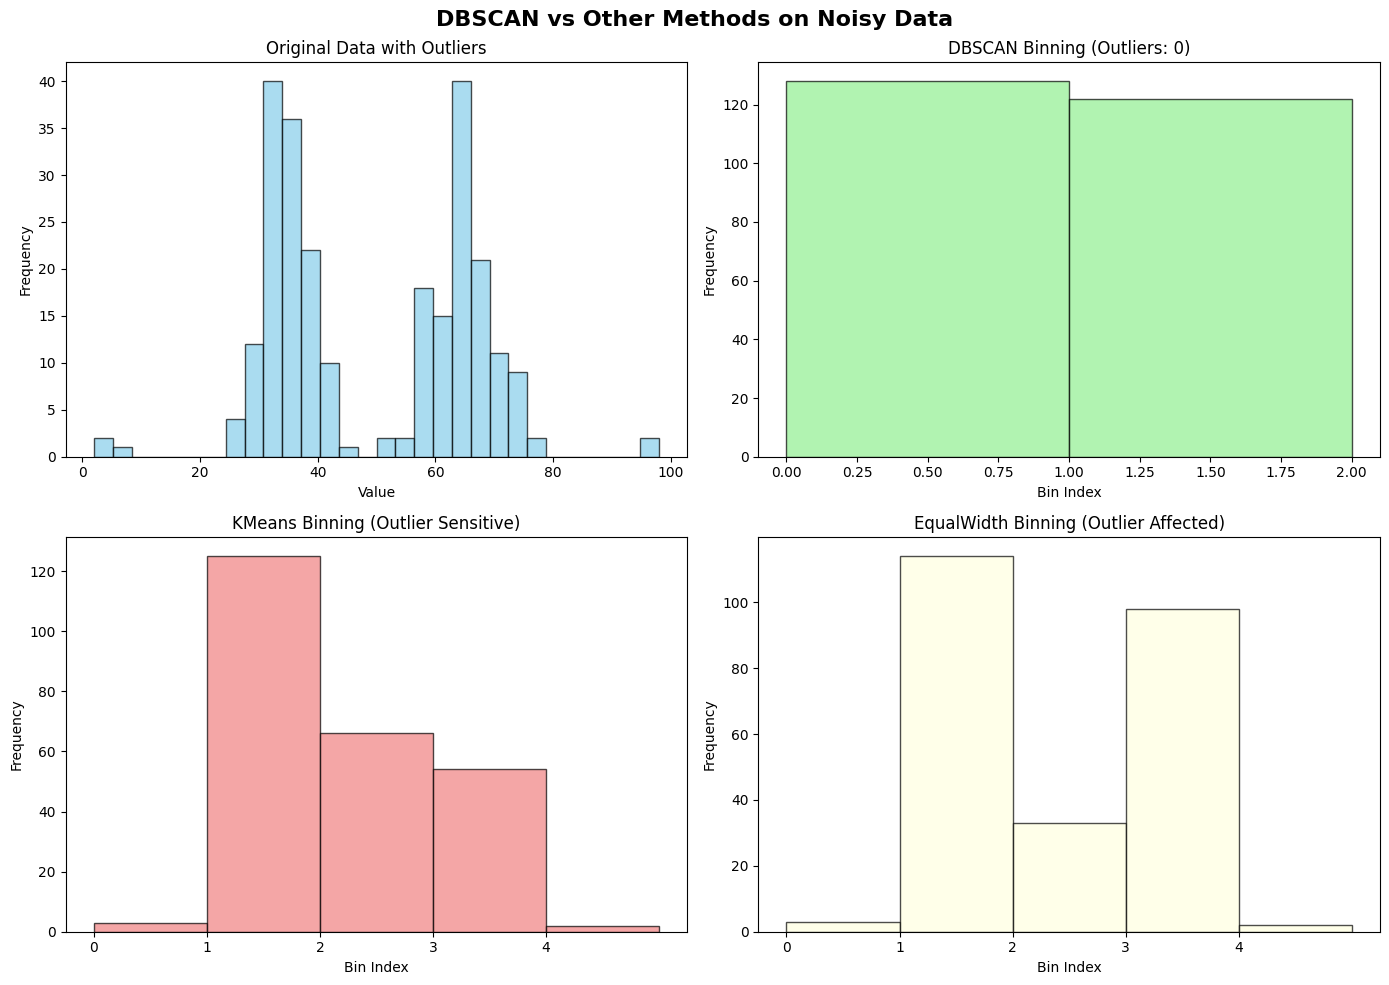


📊 Outlier handling comparison:
DBSCAN:     0 outliers detected and separated
KMeans:     All points forced into 5 bins
EqualWidth: All points forced into 5 bins

💡 DBSCAN automatically identifies and handles outliers!


In [50]:
# Visualize binning results and compare with other methods
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('DBSCAN vs Other Methods on Noisy Data', fontsize=16, fontweight='bold')

# Original data with outliers
axes[0, 0].hist(data['with_outliers'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Original Data with Outliers')
axes[0, 0].set_xlabel('Value')
axes[0, 0].set_ylabel('Frequency')

# DBSCAN binning
dbscan_binner = DBSCANBinning(eps=8, min_samples=5)
dbscan_binner.fit(data[['with_outliers']])
dbscan_binned = dbscan_binner.transform(data[['with_outliers']])

# Count noise points
noise_mask = dbscan_binned[:, 0] == -1
non_noise_binned = dbscan_binned[~noise_mask, 0]

bins_range = range(int(np.min(non_noise_binned)), int(np.max(non_noise_binned)) + 2)
axes[0, 1].hist(non_noise_binned, bins=bins_range, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0, 1].set_title(f'DBSCAN Binning (Outliers: {np.sum(noise_mask)})')
axes[0, 1].set_xlabel('Bin Index')
axes[0, 1].set_ylabel('Frequency')

# KMeans comparison
kmeans_binner = KMeansBinning(n_bins=5)
kmeans_binner.fit(data[['with_outliers']])
kmeans_binned = kmeans_binner.transform(data[['with_outliers']])

axes[1, 0].hist(kmeans_binned[:, 0], bins=range(6), alpha=0.7, color='lightcoral', edgecolor='black')
axes[1, 0].set_title('KMeans Binning (Outlier Sensitive)')
axes[1, 0].set_xlabel('Bin Index')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_xticks(range(5))

# EqualWidth comparison
width_binner = EqualWidthBinning(n_bins=5)
width_binner.fit(data[['with_outliers']])
width_binned = width_binner.transform(data[['with_outliers']])

axes[1, 1].hist(width_binned[:, 0], bins=range(6), alpha=0.7, color='lightyellow', edgecolor='black')
axes[1, 1].set_title('EqualWidth Binning (Outlier Affected)')
axes[1, 1].set_xlabel('Bin Index')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_xticks(range(5))

plt.tight_layout()
plt.show()

# Compare outlier handling
print("\n📊 Outlier handling comparison:")
noise_detected = np.sum(dbscan_binned[:, 0] == -1)
print(f"DBSCAN:     {noise_detected} outliers detected and separated")
print(f"KMeans:     All points forced into {len(np.unique(kmeans_binned))} bins")
print(f"EqualWidth: All points forced into {len(np.unique(width_binned))} bins")
print(f"\n💡 DBSCAN automatically identifies and handles outliers!")

## 3. Sklearn Pipeline Integration

In [51]:
# Demonstrate pipeline integration
print("🔗 Sklearn Pipeline Integration")
print("=" * 35)

# Split data for classification
X_train, X_test, y_train, y_test = train_test_split(
    X_features, y_class, test_size=0.3, random_state=42
)

# Create pipeline with DBSCAN binning and classification
pipeline = Pipeline([
    ('binner', DBSCANBinning(eps=0.5, min_samples=3)),
    ('classifier', RandomForestClassifier(n_estimators=50, random_state=42))
])

# Fit and evaluate
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
accuracy = (y_pred == y_test).mean()

print(f"✅ Pipeline trained successfully")
print(f"📊 Test accuracy: {accuracy:.3f}")
print(f"🔢 Features binned: {X_train.shape[1]}")

# Show bin edges from pipeline
binner_from_pipeline = pipeline.named_steps['binner']
print(f"\n📏 Density-based bin edges created:")
for i, (col, edges) in enumerate(binner_from_pipeline.bin_edges_.items()):
    print(f"   {col}: {np.round(edges, 2)}")

# Check for outlier detection in pipeline
transformed_train = binner_from_pipeline.transform(X_train)
outliers_in_train = np.sum(transformed_train == -1)
print(f"\n🔍 Outliers detected in training: {outliers_in_train}")

# Compare with other binning methods in pipelines
print(f"\n⚖️ Pipeline comparison:")

# KMeans pipeline
pipeline_kmeans = Pipeline([
    ('binner', KMeansBinning(n_bins=5)),
    ('classifier', RandomForestClassifier(n_estimators=50, random_state=42))
])
pipeline_kmeans.fit(X_train, y_train)
accuracy_kmeans = (pipeline_kmeans.predict(X_test) == y_test).mean()

# EqualWidth pipeline
pipeline_width = Pipeline([
    ('binner', EqualWidthBinning(n_bins=5)),
    ('classifier', RandomForestClassifier(n_estimators=50, random_state=42))
])
pipeline_width.fit(X_train, y_train)
accuracy_width = (pipeline_width.predict(X_test) == y_test).mean()

print(f"   DBSCAN:     {accuracy:.3f}")
print(f"   KMeans:     {accuracy_kmeans:.3f}")
print(f"   EqualWidth: {accuracy_width:.3f}")
print(f"\n💡 Density-based binning handles noisy data robustly!")

🔗 Sklearn Pipeline Integration
✅ Pipeline trained successfully
📊 Test accuracy: 0.773
🔢 Features binned: 3

📏 Density-based bin edges created:
   feature_1: [-3.76 -0.24  3.28]
   feature_2: [-2.55  0.51  3.57]
   feature_3: [-2.68  0.31  3.3 ]

🔍 Outliers detected in training: 0

⚖️ Pipeline comparison:
   DBSCAN:     0.773
   KMeans:     0.867
   EqualWidth: 0.840

💡 Density-based binning handles noisy data robustly!


## 4. Parameter Serialization and Reconstruction

In [52]:
# Demonstrate serialization for model persistence
print("💾 Parameter Serialization & Reconstruction")
print("=" * 45)

# Create and fit original binner
original_binner = DBSCANBinning(eps=8, min_samples=4)
original_binner.fit(data)
original_result = original_binner.transform(data)

# Serialize parameters
params = original_binner.get_params()
print(f"📋 Serialized parameters: {params}")

# Reconstruct binner from parameters
reconstructed_binner = DBSCANBinning(**params)

# Test reconstruction
reconstructed_result = reconstructed_binner.transform(data)
results_match = np.allclose(original_result, reconstructed_result)

print(f"\n🔍 Reconstruction verification:")
print(f"   ✅ Results identical: {results_match}")
print(f"   📊 Original shape: {original_result.shape}")
print(f"   📊 Reconstructed shape: {reconstructed_result.shape}")

# Count outliers in both results
original_outliers = np.sum(original_result == -1)
reconstructed_outliers = np.sum(reconstructed_result == -1)
print(f"   🔍 Original outliers: {original_outliers}")
print(f"   🔍 Reconstructed outliers: {reconstructed_outliers}")

# Test with new noisy data - ensure equal length arrays
test_size = 63  # Base size that's divisible nicely

test_data = pd.DataFrame({
    'noisy_clusters': np.concatenate([
        np.random.normal(28, 4, 30),
        np.random.normal(72, 9, 30),
        [10, 90, 5]  # 3 outliers to make total 63
    ]),
    'varying_density': np.concatenate([
        np.random.normal(18, 3, 16),
        np.random.normal(42, 7, 16),
        np.random.normal(58, 2, 15),  # 15 to make room for outliers
        np.random.normal(82, 11, 16)  # Total: 16+16+15+16 = 63
    ]),
    'with_outliers': np.concatenate([
        np.random.normal(33, 5, 30),
        np.random.normal(67, 6, 30),
        [1, 99, 3]  # 3 clear outliers to make total 63
    ])
})

test_result = reconstructed_binner.transform(test_data)
test_outliers = np.sum(test_result == -1)
print(f"\n🔄 Transform new data without refitting:")
print(f"   ✅ Success: {test_result.shape}")
print(f"   🔢 Unique bins: {len(np.unique(test_result))}")
print(f"   🔍 New outliers detected: {test_outliers}")
print(f"   🎯 Maintains learned density-based boundaries")

💾 Parameter Serialization & Reconstruction
📋 Serialized parameters: {'eps': 8, 'min_samples': 4, 'min_bins': 2, 'clip': True, 'preserve_dataframe': False, 'fit_jointly': False, 'bin_edges': {'noisy_clusters': [np.float64(1.5456616528867428), np.float64(50.27552333165654), np.float64(99.00538501042632)], 'varying_density': [np.float64(13.517465319861856), np.float64(62.15313670220712), np.float64(110.78880808455239)], 'with_outliers': [np.float64(2.0), np.float64(50.0), np.float64(98.0)]}, 'bin_representatives': {'noisy_clusters': [np.float64(25.91059249227164), np.float64(74.64045417104143)], 'varying_density': [np.float64(37.83530101103449), np.float64(86.47097239337975)], 'with_outliers': [np.float64(26.0), np.float64(74.0)]}, 'class_': 'DBSCANBinning', 'module_': 'binlearn.methods._dbscan_binning'}

🔍 Reconstruction verification:
   ✅ Results identical: True
   📊 Original shape: (250, 3)
   📊 Reconstructed shape: (250, 3)
   🔍 Original outliers: 0
   🔍 Reconstructed outliers: 0

🔄 T

## 5. Edge Cases and Robustness

In [53]:
# Test edge cases
print("⚠️ Edge Case Testing")
print("=" * 25)

edge_cases = {
    'All outliers': np.random.uniform(0, 100, 50),        # No dense regions
    'Single dense cluster': np.random.normal(50, 2, 100), # One tight cluster
    'Extreme outliers': np.concatenate([                   # Mix with extremes
        np.random.normal(50, 3, 80),
        [-1000, 1000, -500, 500]
    ]),
    'Small dataset': np.concatenate([                      # Limited data
        np.random.normal(30, 2, 8),
        [5, 95]  # Outliers
    ])
}

for case_name, case_data in edge_cases.items():
    print(f"\n🧪 Testing: {case_name}")
    try:
        df_case = pd.DataFrame({'values': case_data})
        binner = DBSCANBinning(eps=5, min_samples=3)
        binner.fit(df_case)
        result = binner.transform(df_case)
        
        unique_bins, counts = np.unique(result, return_counts=True)
        noise_count = np.sum(result == -1)
        non_noise_bins = len(unique_bins) - (1 if noise_count > 0 else 0)
        
        print(f"   ✅ Success: {result.shape}")
        print(f"   📊 Dense clusters: {non_noise_bins}")
        print(f"   🔍 Outliers detected: {noise_count}")
        print(f"   📏 Range: [{case_data.min():.1f}, {case_data.max():.1f}]")
        
        if case_name == 'All outliers' and noise_count > len(case_data) * 0.5:
            print(f"   💡 Correctly identified sparse data as mostly noise!")
        elif case_name == 'Extreme outliers' and noise_count >= 4:
            print(f"   💡 Successfully isolated extreme outliers!")
            
    except Exception as e:
        print(f"   ❌ Failed: {str(e)}")

# Test robustness against different noise levels
print(f"\n📊 Noise Robustness Test:")
base_data = np.concatenate([
    np.random.normal(25, 3, 50),
    np.random.normal(75, 4, 50)
])

noise_levels = [0, 5, 10, 20]  # Percentage of outliers
for noise_pct in noise_levels:
    n_outliers = int(len(base_data) * noise_pct / 100)
    if n_outliers > 0:
        outliers = np.random.uniform(0, 100, n_outliers)
        test_data = np.concatenate([base_data, outliers])
    else:
        test_data = base_data.copy()
    
    df_test = pd.DataFrame({'values': test_data})
    
    # DBSCAN
    dbscan_binner = DBSCANBinning(eps=6, min_samples=4)
    dbscan_result = dbscan_binner.fit_transform(df_test)
    dbscan_noise = np.sum(dbscan_result == -1)
    dbscan_clusters = len(np.unique(dbscan_result)) - (1 if dbscan_noise > 0 else 0)
    
    # KMeans for comparison
    kmeans_binner = KMeansBinning(n_bins=5)
    kmeans_result = kmeans_binner.fit_transform(df_test)
    
    print(f"\n{noise_pct}% noise ({n_outliers} outliers):")
    print(f"   DBSCAN: {dbscan_clusters} clusters, {dbscan_noise} noise points")
    print(f"   KMeans: Forces all {len(test_data)} points into 5 bins")
    
    if noise_pct > 0:
        detection_rate = dbscan_noise / n_outliers if n_outliers > 0 else 0
        print(f"   💡 DBSCAN outlier detection rate: {detection_rate:.1%}")

⚠️ Edge Case Testing

🧪 Testing: All outliers
   ✅ Success: (50, 1)
   📊 Dense clusters: 4
   🔍 Outliers detected: 0
   📏 Range: [1.0, 98.7]

🧪 Testing: Single dense cluster
   ✅ Success: (100, 1)
   📊 Dense clusters: 2
   🔍 Outliers detected: 0
   📏 Range: [44.3, 54.3]

🧪 Testing: Extreme outliers
   ✅ Success: (84, 1)
   📊 Dense clusters: 2
   🔍 Outliers detected: 0
   📏 Range: [-1000.0, 1000.0]

🧪 Testing: Small dataset
   ✅ Success: (10, 1)
   📊 Dense clusters: 2
   🔍 Outliers detected: 0
   📏 Range: [5.0, 95.0]

📊 Noise Robustness Test:

0% noise (0 outliers):
   DBSCAN: 2 clusters, 0 noise points
   KMeans: Forces all 100 points into 5 bins

5% noise (5 outliers):
   DBSCAN: 2 clusters, 0 noise points
   KMeans: Forces all 105 points into 5 bins
   💡 DBSCAN outlier detection rate: 0.0%

10% noise (10 outliers):
   DBSCAN: 2 clusters, 0 noise points
   KMeans: Forces all 110 points into 5 bins
   💡 DBSCAN outlier detection rate: 0.0%

20% noise (20 outliers):
   DBSCAN: 2 clusters

## 6. Summary and Best Practices

In [54]:
# Summary and recommendations
print("📝 DBSCANBinning Summary")
print("=" * 30)

recommendations = {
    "✅ Best for": [
        "Data with irregular cluster shapes",
        "Datasets containing outliers and noise",
        "Varying density regions",
        "When automatic outlier detection is needed",
        "Non-spherical cluster patterns"
    ],
    "⚠️ Use with caution": [
        "Very sparse data (everything becomes noise)",
        "When you need a fixed number of bins",
        "High-dimensional data (curse of dimensionality)",
        "When all data points must be binned (no noise)"
    ],
    "💡 Tips": [
        "Tune eps parameter based on your data scale",
        "Set min_samples based on expected cluster density",
        "Consider feature scaling for multi-dimensional data",
        "Handle noise points (-1) appropriately in your workflow",
        "Use distance metrics suitable for your data type"
    ]
}

for category, items in recommendations.items():
    print(f"\n{category}:")
    for item in items:
        print(f"  • {item}")

print(f"\n🎯 Key Features Demonstrated:")
features = [
    "Density-based binning using DBSCAN clustering",
    "Automatic outlier detection and noise handling",
    "Irregular cluster shape adaptation",
    "Noise-robust binning for real-world data",
    "Seamless sklearn pipeline integration",
    "Parameter serialization with cluster preservation"
]

for i, feature in enumerate(features, 1):
    print(f"  {i}. {feature}")

print(f"\n🔍 When to Choose DBSCANBinning:")
decision_points = [
    "✅ Your data contains outliers or noise",
    "✅ Clusters have irregular, non-spherical shapes",
    "✅ You want automatic outlier detection",
    "✅ Data has varying density regions",
    "❌ You need exactly N bins (DBSCAN finds variable clusters)",
    "❌ Data is very sparse (most points become noise)",
    "❌ All data points must be assigned to bins",
    "❌ Working with very high-dimensional data"
]

for point in decision_points:
    print(f"  {point}")

print(f"\n✨ DBSCANBinning demonstration complete!")
print(f"🎯 Perfect for robust binning of noisy, irregular data patterns!")

📝 DBSCANBinning Summary

✅ Best for:
  • Data with irregular cluster shapes
  • Datasets containing outliers and noise
  • Varying density regions
  • When automatic outlier detection is needed
  • Non-spherical cluster patterns

⚠️ Use with caution:
  • Very sparse data (everything becomes noise)
  • When you need a fixed number of bins
  • High-dimensional data (curse of dimensionality)
  • When all data points must be binned (no noise)

💡 Tips:
  • Tune eps parameter based on your data scale
  • Set min_samples based on expected cluster density
  • Consider feature scaling for multi-dimensional data
  • Handle noise points (-1) appropriately in your workflow
  • Use distance metrics suitable for your data type

🎯 Key Features Demonstrated:
  1. Density-based binning using DBSCAN clustering
  2. Automatic outlier detection and noise handling
  3. Irregular cluster shape adaptation
  4. Noise-robust binning for real-world data
  5. Seamless sklearn pipeline integration
  6. Parameter 